# Chapter5. Monte-Carlo Method
---

### Import grid environment

In [1]:
import import_ipynb
from grid_env_55 import GridEnv, policy_visualize, ActionValueFunction_visualize
from tqdm import tqdm

import numpy as np
import random
import time
from copy import deepcopy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

importing Jupyter notebook from GridEnv55.ipynb


### Model-based case
Q value function is $\textbf{evaluated}$ by below equation

- $Q_{k+1}(s,a) = \sum_{s'} P(s'|s,a) \left[r(s,a,s') + \gamma \sum_{a'} Q_{k}(s',a') \pi(a'|s') \right]$

### Model-free case
Q value function is $\textbf{predicted}$ or updated by below equation 

- $Q_{new}(S_{t}, A_{t}) \leftarrow Q_{old}(S_{t}, A_{t}) + \alpha (G_{t} - Q_{old}(S_{t}, A_{t}))$


### About Monte-Carlo Method
Monte-Carlo Method update value function after the episode is terminated

Given $(S_{0}, A_{0}, R_{1}, S_{1}, A_{1}, R_{2}, \dots, S_{T}, A_{T}, R_{T+1}, S_{T+1})$, $G_{t}$ can be computed using $G_t = R_{t+1} + \gamma G_{t+1}$

### Generate random epsilon greedy policy

In [2]:
# 4 actions and 100 states -> 4x100 size
def RandomEpsilsonPolicy_generation(env, e=0.1):
    policy = np.zeros([len(env.obs_space), len(env.action_space)])
    for s in range(len(env.obs_space)):
        GreedyAction = np.random.randint(len(env.action_space))
        NonGreedyActions = [a for a in env.action_space if a != GreedyAction]
        
        policy[s][GreedyAction] = 1 - e + e/len(env.action_space)
        for a in NonGreedyActions:
            policy[s][a] = e/len(env.action_space)
            
    return policy

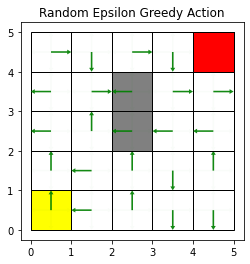

In [3]:
env = GridEnv()
policy = RandomEpsilsonPolicy_generation(env, e=0.1)
policy_visualize(env, policy, "Random Epsilon Greedy Action")

### Generate Episode with given policy

In [4]:
def EpisodeGenerator(env, policy):
    env =  GridEnv()
    obs = env.reset()
    
    StateAction_pairs = []
    rewards = [0] # 0 is for indexing
    
    t = 0
    while True:
        action = random.choices(env.action_space, weights=policy[obs])[0]
        StateAction_pairs.append((obs,action))
        
        reward, obs_nxt, done, info = env.step(action)
        
        rewards.append(reward)
        
        obs = obs_nxt
        t += 1
        if done:
            break
    
    return StateAction_pairs, rewards, t

In [5]:
def update_epsilon(t):
    if t < 100:
        return 1
    elif 100 <= t < 1000:
        return 0.8
    elif 1000 <= t < 10000:
        return 0.4
    else:
        return 0.2

### 1. On-policy First Visit MC Control
#### Policy Improvement

- $\pi(a|s) = \frac{\epsilon}{A(s)} + (1-\epsilon) \left(a = \max_{a'} Q(s,a')\right)$

In [6]:
def OnPolicy_MC(loop, env, e=0.8, gamma=0.99, alpha=0.1):
    """
    First-visit MC method
    """
    # Extract environment information
    n_state = len(env.obs_space)
    n_action = len(env.action_space)
    
    # initialize
    policy = RandomEpsilsonPolicy_generation(env, e)
    Q = np.zeros([n_state, n_action])
    Q_history = [np.zeros([n_state, n_action])]
    Convergence = []
    
    for i in tqdm(range(loop)):
        # generate episode with given policy
        StateAction_pairs, rewards, EndTime = EpisodeGenerator(env, policy)
        G = 0
        
        for t in range(EndTime-1, -1, -1): # T-1, T-2, ..., 0
            G = gamma*G + rewards[t+1]
            # first visit
            if StateAction_pairs[t] not in StateAction_pairs[:t]:
                s_t = StateAction_pairs[t][0]
                a_t = StateAction_pairs[t][1]
                
                # update Q value
                Q[s_t][a_t] = Q[s_t][a_t] + alpha*(G - Q[s_t][a_t])

                # update epsilon-greedy policy
                GreedyActions = np.where(Q[s_t] == np.max(Q[s_t]))[0]
                GreedyAction = random.choice(GreedyActions)
                NonGreedyActions = [a for a in env.action_space if a != GreedyAction]
                
                # decaying epsilson
                e = update_epsilon(i)
                policy[s_t][GreedyAction] = 1 - e + e/len(env.action_space)
                for a in NonGreedyActions:
                    policy[s_t][a] = e/len(env.action_space)
        
        Q_store = deepcopy(Q)
        Q_history.append(Q_store)
        Convergence.append(np.sum(Q_store))
        
    return Q, Q_history, Convergence, policy

#### 1.1. Run On-policy First Visit MC Control

In [7]:
start = time.time()
Q, Q_history, Convergence, policy = OnPolicy_MC(10000, env, e=0.8, gamma=0.99, alpha=0.1)
print("\nIt took [{:.2f}]s.".format(time.time()-start))
print ("Policy evaluation converged in [{}] loops.".format(len(Q_history)))

100%|██████████| 10000/10000 [00:05<00:00, 1933.09it/s]


It took [5.18]s.
Policy evaluation converged in [10001] loops.


#### 1.2. Plot the convergence of On-policy First Visit MC Control

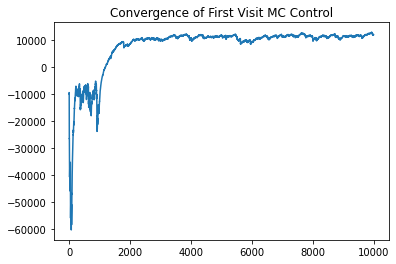

In [8]:
plt.plot(Convergence)
plt.title("Convergence of First Visit MC Control")
plt.show()

#### 1.3. Visualize Optimal Policy and Optimal Action Value Function

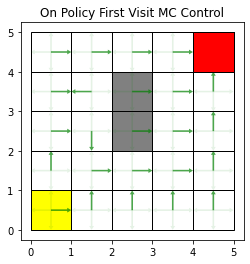

In [9]:
policy_visualize(env, policy, "On Policy First Visit MC Control")

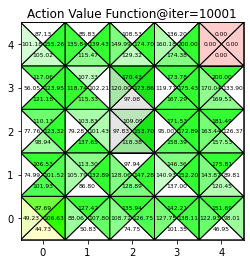

In [10]:
ActionValueFunction_visualize(env, Q_history[-1], title="Action Value Function@iter={}".format(len(Q_history)))

### 2. Off-policy MC Control

In [11]:
def GreedyPolicy_generation(env, Q):
    """
    Generate Greedy Policy with Q value
    """
    policy = np.zeros([len(env.obs_space), len(env.action_space)])
    for s in range(len(env.obs_space)):
        if s == 99:
            continue
            
        max_actions = np.where(Q[s] == np.max(Q[s]))[0]
        GreedyAction = np.random.choice(max_actions)
        
        policy[s][GreedyAction] = 1
            
    return policy

In [12]:
def update_epsilon(t):
    if t < 1000:
        return 1
    elif 1000 <= t < 10000:
        return 0.8
    elif 10000 <= t < 100000:
        return 0.4
    elif 100000 <= t:
        return 0.2

In [13]:
Q = np.zeros([100, 4])
TargetPolicy = GreedyPolicy_generation(env, Q)
TargetPolicy[0] = np.zeros(4)
# TargetPolicy

In [14]:
BehaviorPolicy = RandomEpsilsonPolicy_generation(env, e=0.8)
StateAction_pairs, rewards, EndTime = EpisodeGenerator(env, BehaviorPolicy)
# rewards

In [15]:
def OffPolicy_MC(loop, env, gamma=0.99, alpha=0.1):
    """
    Off Policy MC method
    """
    # Extract environment information
    n_state = len(env.obs_space)
    n_action = len(env.action_space)
    
    # initialize
    Q = np.zeros([n_state, n_action])
    Q_history = [np.zeros([n_state, n_action])]
    C = np.zeros([n_state, n_action]) # accumulated sum of weights
    Convergence = []
    
    # generate greedy policy to Q(s,a)
    TargetPolicy = GreedyPolicy_generation(env, Q)
    
    for i in tqdm(range(loop)):
        # random epsilon soft behavior policy
        # decaying epsilson for behavior policy
        e = update_epsilon(i)
        BehaviorPolicy = RandomEpsilsonPolicy_generation(env, e)
        # generate episode with given policy
        StateAction_pairs, rewards, EndTime = EpisodeGenerator(env, BehaviorPolicy)
        G = 0
        W = 1
        
        for t in range(EndTime-1, -1, -1): # T-1, T-2, ..., 0
            G = gamma*G + rewards[t+1]

            s_t = StateAction_pairs[t][0]
            a_t = StateAction_pairs[t][1]
                
            # update C value
            C[s_t][a_t] = C[s_t][a_t] + W
            # update Q value
            Q[s_t][a_t] = Q[s_t][a_t] + (W/C[s_t][a_t])*(G - Q[s_t][a_t])
            
            # update target policy
            max_actions = np.where(Q[s_t] == np.max(Q[s_t]))[0]
            GreedyAction = np.random.choice(max_actions)
            TargetPolicy[s_t] = np.zeros(4)
            TargetPolicy[s_t][GreedyAction] = 1
            
            if a_t != GreedyAction:
                break
            W /= BehaviorPolicy[s_t][a_t]
        
        Q_store = deepcopy(Q)
        Q_history.append(Q_store)
        Convergence.append(np.sum(Q_store))
        
    return Q, Q_history, Convergence, TargetPolicy

#### 2.1. Run Off-policy MC Control

In [16]:
start = time.time()
Q, Q_history, Convergence, TargetPolicy = OffPolicy_MC(50000, env, gamma=0.99, alpha=0.1)
print("\nIt took [{:.2f}]s.".format(time.time()-start))
print ("Policy evaluation converged in [{}] loops.".format(len(Q_history)))

100%|██████████| 50000/50000 [02:08<00:00, 388.00it/s]


It took [128.87]s.
Policy evaluation converged in [50001] loops.


#### 2.2. Plot the convergence of Off-policy MC Control

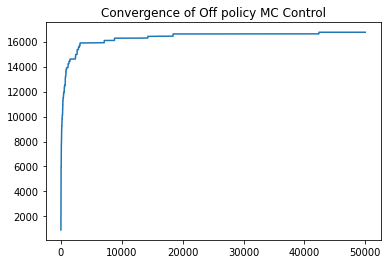

In [17]:
plt.plot(Convergence)
plt.title("Convergence of Off policy MC Control")
plt.show()

#### 2.3. Visualize Optimal Policy and Optimal Action Value Function

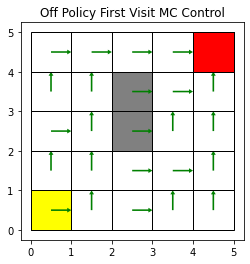

In [18]:
policy_visualize(env, TargetPolicy, "Off Policy First Visit MC Control")

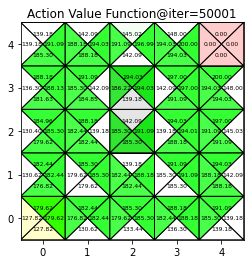

In [20]:
ActionValueFunction_visualize(env, Q_history[-1], title="Action Value Function@iter={}".format(len(Q_history)))